# Lab - Recommender System


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

/Users/anna-mariasjolund/.local/share/virtualenvs/Machine-learning-Anna-MariaSjolund-8kbAf2Oi/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### 1.1 - Movielens full - EDA
Nu ska du ladda ned datasetet ml-latest.zip under sektionen "recommended for education and
development". Ladda in dataseten "movies.csv" och "ratings.csv" besvara på följande frågor:

a) Gör en EDA för att förstå datasetet. Inkludera olika slags plots. Begränsa dig inte till frågorna nedan,
utan försök undersöka fler aspekter av datan.

In [2]:
movies = pd.read_csv("../../Data/ml-latest/movies.csv")
ratings = pd.read_csv("../../Data/ml-latest/ratings.csv")

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


There are movies in the movies dataset (title and genre) that are not included in the ratings dataset (see below). Since I would like to explore the number of movies from each genre I remove the movies with no ratings, prior to analysis. 

In [3]:
print(f"Number of unique movies in the movies dataset: {movies['movieId'].nunique()}")
print(f"Number of unique movies in the ratings dataset: {ratings['movieId'].nunique()}") 

Number of unique movies in the movies dataset: 58098
Number of unique movies in the ratings dataset: 53889


In [4]:
movies[~movies["movieId"].isin(ratings["movieId"])]

,movieId,title,genres
8403,25817,Break of Hearts (1935),Drama|Romance
8800,26361,Baby Blue Marine (1976),Drama
9221,27153,Can't Be Heaven (Forever Together) (2000),Children|Comedy|Drama|Romance
9336,27433,Bark! (2002),Comedy|Drama
9809,31945,Always a Bridesmaid (2000),Documentary
...,...,...,...
57522,192399,Under Wraps (1997),Children|Comedy|Horror
57718,192933,Rosie (2018),Drama
57773,193109,Ach śpij kochanie (2017),Crime|Thriller
57854,193321,Pledges (2018),Comedy|Horror


In [7]:
movies = movies[movies["movieId"].isin(ratings["movieId"])]
print(f"Number of unique movies in the movies dataset: {ratings['movieId'].nunique()}")
print(f"Number of unique movies in the ratings dataset: {ratings['movieId'].nunique()}")

Number of unique movies in the movies dataset: 53889
Number of unique movies in the ratings dataset: 53889


Next, I want to examine the different genres represented in the dataset and the number of movies from each genre. A movie can be part of several genres and can therefore be counted several times. 

In [10]:
# Picks out the unique genres

all_genres = movies["genres"].unique() # Picks out all unique combinations of genres to ease the loop
genres = []

for genre in all_genres:
    genres.extend(genre.split("|")) # Splits the genre information into the individual genres and add them to the list

unique_genres = list(set(genres)) # Picks out the unique genres
unique_genres.remove("(no genres listed)")


# Count the number of occurences for each genre

number_of_occurences = []

for genre in unique_genres:
    number_of_occurences.append(movies["genres"].str.count(genre).sum()) 

genres_occurences = pd.DataFrame({"Genre" : unique_genres, "Occurences" : number_of_occurences}).sort_values("Occurences")
genres_occurences

,Genre,Occurences
13,IMAX,197
1,Film-Noir,360
12,Musical,1075
9,Western,1092
7,War,1686
17,Fantasy,2558
4,Mystery,2574
15,Animation,2640
6,Children,2665
11,Sci-Fi,3317


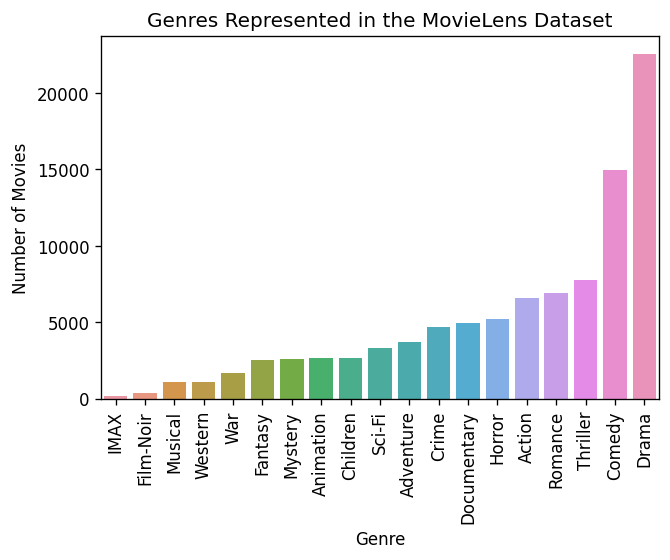

In [16]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=genres_occurences["Genre"], y=genres_occurences["Occurences"])

ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);
ax.set(title="Genres Represented in the MovieLens Dataset", ylabel="Number of Movies");

I would also like to explore the mean rating per genre. Again, a movie can be counted several times if it belongs to several genres.

In [13]:
# Calculates mean rating per genre

movie_means = pd.DataFrame(ratings["rating"].groupby(ratings["movieId"]).mean()).reset_index() # Calculates mean rating for each movie
movie_means = movie_means.merge(movies, how="left", on="movieId") # Merge with the movies dataset
genre_means = [] 

for genre in unique_genres: # Loops through the unique genres

    temp = pd.DataFrame({"Mean_rating" : movie_means["rating"],
                        "Contains_value" : movie_means["genres"].str.contains(genre)}) # Check if the string contains the genre or not

    temp = pd.DataFrame(temp["Mean_rating"].groupby(temp["Contains_value"]).mean().reset_index()) # Returns the mean rating, for True and False
    
    genre_means.append(temp["Mean_rating"][1]) # [1] is the second row in the dataframe, Contains_value is True

genres_rating = pd.DataFrame({"Genre" : unique_genres, "Mean Rating" : genre_means}).sort_values("Mean Rating")
genres_rating

,Genre,Mean Rating
5,Horror,2.595426
11,Sci-Fi,2.769681
10,Action,2.910727
16,Thriller,2.912710
0,Adventure,3.006427
6,Children,3.006498
9,Western,3.022282
17,Fantasy,3.035745
4,Mystery,3.039553
2,Comedy,3.051817


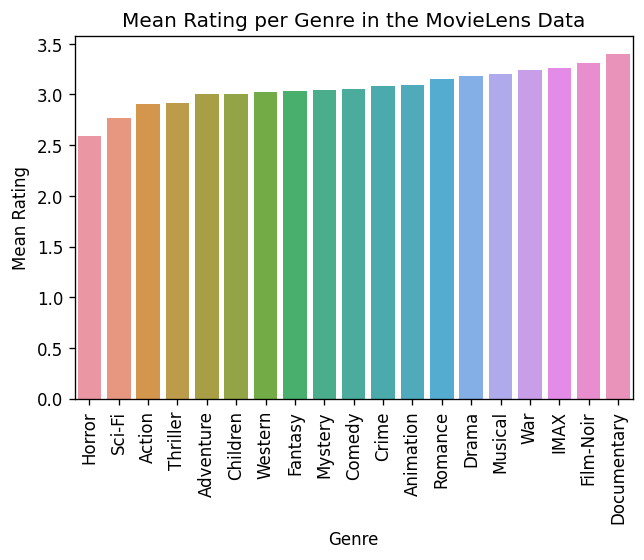

In [15]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=genres_rating["Genre"], y=genres_rating["Mean Rating"])

ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);
ax.set(title="Mean Rating per Genre in the MovieLens Data");

I also want to plot the number of ratings per user, in order to see if I can remove some of the users with low ratings later. In the first plot, there are some users with very high number of ratings, which makes the plot difficult to interpret.

In [17]:
ratings_per_user = pd.DataFrame(ratings["userId"].value_counts()).reset_index()
ratings_per_user = ratings_per_user.rename({"index" : "userId", "userId" : "Number of Ratings"}, axis=1)
ratings_per_user

,userId,Number of Ratings
0,123100,23715
1,117490,9279
2,134596,8381
3,212343,7884
4,242683,7515
...,...,...
283223,188125,1
283224,117282,1
283225,127062,1
283226,241836,1


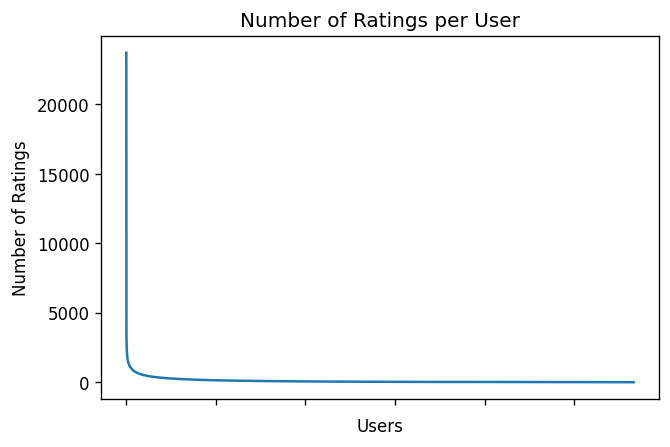

In [19]:
fig = plt.figure(dpi=120)
ax = sns.lineplot(x=ratings_per_user.index, y=ratings_per_user["Number of Ratings"])
ax.set_xticklabels([]);
ax.set(xlabel="Users", title="Number of Ratings per User");

Since the outliers make it difficult to interpret the plot, I drop the 3000 most extreme values. From the plot below we can see that the majority of people have rated less than 200 movies. 

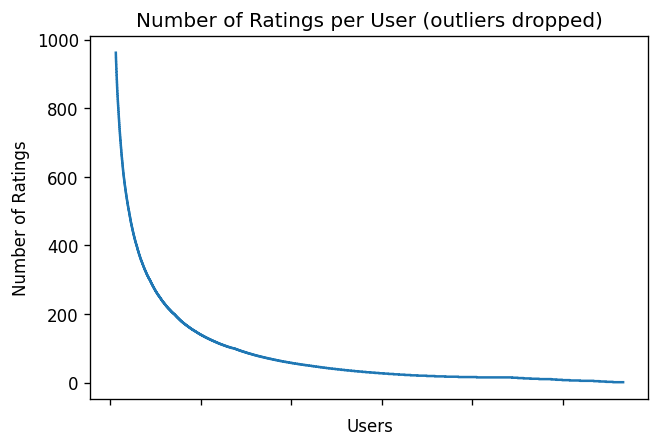

In [20]:
ratings_per_user = ratings_per_user.iloc[3000:] 

fig = plt.figure(dpi=120)

ax = sns.lineplot(x=ratings_per_user.index, y=ratings_per_user["Number of Ratings"])
ax.set_xticklabels([]);
ax.set(xlabel="Users", title="Number of Ratings per User (outliers dropped)");

b) Vilka är de 10 filmerna med flest ratings?

In [21]:
most_ratings = ratings["rating"].groupby(ratings["movieId"]).count()

most_ratings = pd.DataFrame(most_ratings.sort_values(ascending=False).head(10)).reset_index()
most_ratings = most_ratings.rename({"rating":"Number of Ratings"}, axis=1)

movies_most_ratings = pd.merge(most_ratings, 
                            movies.loc[movies["movieId"].isin(most_ratings["movieId"])], 
                            on="movieId"
                            )
movies_most_ratings

,movieId,Number of Ratings,title,genres
0,318,97999,"Shawshank Redemption, The (1994)",Crime|Drama
1,356,97040,Forrest Gump (1994),Comedy|Drama|Romance|War
2,296,92406,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,87899,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,84545,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,81815,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,76451,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,71516,Schindler's List (1993),Drama|War
8,110,68803,Braveheart (1995),Action|Drama|War
9,1,68469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


c) Beräkna den genomsnittliga ratingen för dessa 10 filmerna med flest ratings.

In [22]:
rating_of_most_rated = ratings.loc[ratings["movieId"].isin(most_ratings["movieId"])] # Picks out all ratings for the top ten most rated movies
rating_of_most_rated = rating_of_most_rated["rating"].groupby(rating_of_most_rated["movieId"]).mean()

movies_most_rated = pd.merge(movies_most_ratings, 
                            pd.DataFrame({"Mean Rating" : rating_of_most_rated}).reset_index(), 
                            on="movieId").sort_values("Mean Rating")
movies_most_rated


,movieId,Number of Ratings,title,genres,Mean Rating
6,480,76451,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.665034
9,1,68469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649
8,110,68803,Braveheart (1995),Action|Drama|War,4.008481
1,356,97040,Forrest Gump (1994),Comedy|Drama|Romance|War,4.056585
5,260,81815,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.120455
4,2571,84545,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.149695
3,593,87899,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.151412
2,296,92406,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.173971
7,527,71516,Schindler's List (1993),Drama|War,4.257502
0,318,97999,"Shawshank Redemption, The (1994)",Crime|Drama,4.424188


d) Gör en plot över årtal och antalet filmer representerade i datasettet.

In [23]:
year_of_movies = movies["title"].str.extract(r"(\(\d{4}\))") # Extract all years in the format (dddd)
year_of_movies = year_of_movies[0].str.extract(r"(\d{4})").rename({0:"Year"}, axis=1) # Removes the parenthesis and renames the column
year_of_movies = pd.DataFrame(year_of_movies["Year"].dropna().astype(int))
year_of_movies

,Year
0,1995
1,1995
2,1995
3,1995
4,1995
...,...
58093,1946
58094,2011
58095,2016
58096,2017


In [24]:
movies_per_year = pd.DataFrame(year_of_movies["Year"].value_counts()).rename({"Year" : "Count"}, axis=1)
movies_per_year = movies_per_year.drop(2018)
movies_per_year

,Count
2015,2233
2014,2205
2016,2143
2013,2115
2012,1956
...,...
1887,1
1878,1
1874,1
1883,1


In the plot below the year 2018 has been removed, since the data is insufficient for this year (dataset was updated 9/2018) and the plot would otherwise show a large decrease in the number of movies for that year.

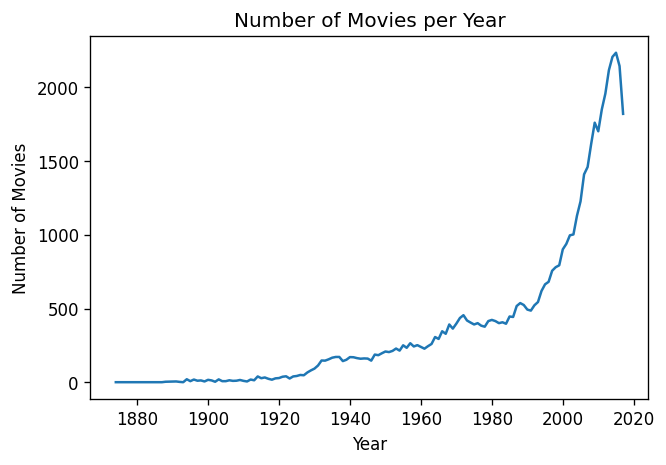

In [34]:
fig = plt.figure(dpi=120)
ax = sns.lineplot(x=movies_per_year.index, y=movies_per_year["Count"])
_ = ax.set(title="Number of Movies per Year", xlabel="Year", ylabel="Number of Movies")

I also wondered what the title of the earliest movie was. It turns out that this is Passage de Venus from 1874, which is a series of photographs showing how Venus transits the Sun. 

In [28]:
year_of_movies["Year"].min()

1874

In [29]:
movies.loc[movies["title"].str.contains("1874")]

,movieId,title,genres
37886,148054,Passage de Venus (1874),Documentary


e) Gör en plot över antalet ratings mot movieId.

In [30]:
ratings_per_movieId = pd.DataFrame(ratings["rating"].groupby(ratings["movieId"]).count()).reset_index()
ratings_per_movieId

,movieId,rating
0,1,68469
1,2,27143
2,3,15585
3,4,2989
4,5,15474
...,...,...
53884,193876,1
53885,193878,1
53886,193880,1
53887,193882,1


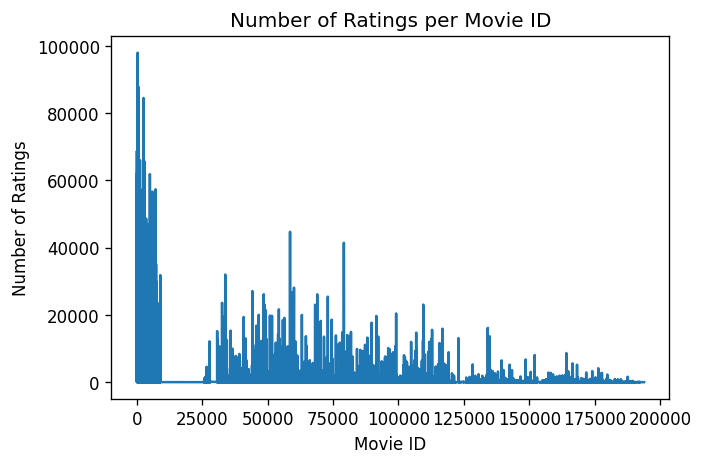

In [32]:
fig = plt.figure(dpi=120)
ax = sns.lineplot(x=ratings_per_movieId["movieId"], y=ratings_per_movieId["rating"])
ax.set(title="Number of Ratings per Movie ID", xlabel="Movie ID", ylabel="Number of Ratings");

f) Beräkna genomsnittliga ratings för de top 10 filmerna med flest ratings. Gör ett stapeldiagram över
dessa.

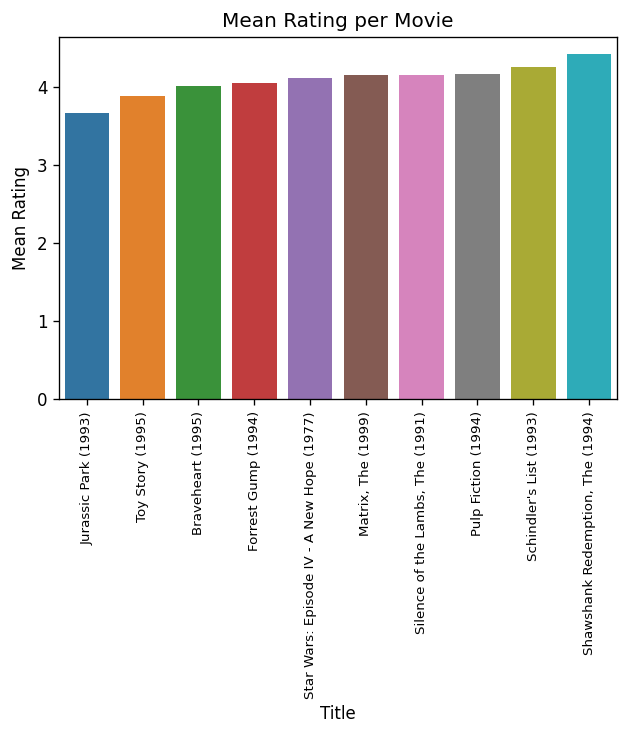

In [42]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=movies_most_rated["title"], y=movies_most_rated["Mean Rating"])
ax.set(title="Mean Rating per Movie", xlabel="Title")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=8)

### 1.2 Skapa gles matris
Likt i videon i uppgift 1.0 skapade du en pivottabell av dataframet med index "movieId", columns "userId"
och values "ratings". Denna pivottabell är dock "dyrt" att skapa och förmodligen kommer inte din dator att
klara av skapa den om du inte filtrerar bort viss data. Fundera ut ett lämpligt sätt att filtrera ditt dataset,
prova dig fram och motivera.
Skapa en gles (sparse) matris med hjälp av denna pivottabell.

It is very common that movie recommendation systems are based on data collected from a few active users. Furthermore, the most popular movies have a lot of ratings and some movies have barely any ratings at all. This makes the dataset sparse and can lead ratings being less predictable and also more affected by users who rate obscure movies highly.<a href="#Liao(2018)" id="note1ref"><sup>1</sup></a> I will therefore start with removing the movies with few ratings.

In [35]:
ratings = ratings.drop("timestamp", axis=1) # Drops the timestamp column
ratings

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


In [36]:
# Calculates the number of ratings per movie
number_of_ratings = pd.DataFrame(ratings["rating"].groupby(ratings["movieId"]).count()).reset_index()
number_of_ratings["rating"].describe()

count    53889.000000
mean       515.011301
std       2934.758939
min          1.000000
25%          2.000000
50%          7.000000
75%         48.000000
max      97999.000000
Name: rating, dtype: float64

75 % of the movies have a mean rating under 48. I choose to base my decision on the median, rather than the mean, since the data seems to be skewed with some very popular movies that increases the mean. Consequently, I drop all movies that have been rated fewer than 48 times.

In [37]:
few_ratings = pd.DataFrame(number_of_ratings[number_of_ratings["rating"] < 48]).reset_index(drop=True)

reduced_ratings = ratings[~ratings["movieId"].isin(few_ratings["movieId"])]
reduced_ratings

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


In [40]:
print(f"The number of unique movies are reduced from {ratings['movieId'].nunique()} to {reduced_ratings['movieId'].nunique()} movies.")
print(f"This reduced the number of rows from {len(ratings)} to {len(reduced_ratings)} rows.")

The number of unique movies are reduced from 53889 to 13534 movies.
This reduced the number of rows from 27753444 to 27439194 rows.


This reduced the number of rows from 27753444 to 27439194. However, this is still too high for pivot to work. I therefore continue to calculate the number of ratings for each user. From the descriptive statistics below, we can see that 75% of the participants have rated less than 94 movies.

As explained at the end of this lab, the recommendation system will use an item based collaborative filtering approach. Such a recommendation system is based on the assumption that users likes and dislikes the same types of movies, which gives these movies a similar profile.<a href="#Jeong(2021)" id="note2ref"><sup>2</sup></a> The users with fewer ratings contribute less to the unique movies profile and I will therefore remove them. 

In [41]:
number_of_ratings = pd.DataFrame(reduced_ratings["userId"].value_counts()).reset_index()
number_of_ratings = number_of_ratings.rename({"index" : "userId", "userId" : "Number of Ratings"}, axis=1)
number_of_ratings["Number of Ratings"].describe()

count    283114.000000
mean         96.919241
std         200.973912
min           1.000000
25%          15.000000
50%          30.000000
75%          94.000000
max        9491.000000
Name: Number of Ratings, dtype: float64

In [42]:
few_ratings = number_of_ratings[number_of_ratings["Number of Ratings"] < 94]

reduced_ratings = reduced_ratings[~reduced_ratings['userId'].isin(few_ratings["userId"])]
reduced_ratings

,userId,movieId,rating
42,4,1,4.0
43,4,2,4.0
44,4,5,2.0
45,4,6,4.5
46,4,10,4.0
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


In [43]:
print(f"The number of users are reduced from {ratings['userId'].nunique()} to {reduced_ratings['userId'].nunique()} users.")
print(f"This reduced the number of rows from {len(ratings)} to {len(reduced_ratings)} rows.")

The number of users are reduced from 283228 to 71278 users.
This reduced the number of rows from 27753444 to 21583429 rows.


I also change the datatype so that the data should use less memory. 

In [44]:
print(f"Max value for userId: {reduced_ratings['userId'].max()}")
print(f"Max value for movieId: {reduced_ratings['movieId'].max()} \n")
reduced_ratings.info()

Max value for userId: 283228
Max value for movieId: 192307 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21583429 entries, 42 to 27753443
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 658.7 MB


In [45]:
reduced_ratings = reduced_ratings.astype({"userId": np.int32, "movieId": np.int32, "rating": np.float32})

In [46]:
print(f"Max value for userId: {reduced_ratings['userId'].max()}")
print(f"Max value for movieId: {reduced_ratings['movieId'].max()} \n")
reduced_ratings.info()

Max value for userId: 283228
Max value for movieId: 192307 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21583429 entries, 42 to 27753443
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 411.7 MB


In [47]:
# Run pivot on the reduced data
movies_users = reduced_ratings.pivot(index="movieId", columns="userId", values="rating").fillna(0)

In [50]:
# Reset index for the pivoted data, so that movieId can be reached
movies_users = movies_users.reset_index()
movies_users

userId,movieId,4,10,14,15,19,26,36,38,42,...,283171,283183,283184,283185,283195,283199,283204,283206,283224,283228
0,1,4.0,5.0,4.5,4.0,0.0,0.0,0.0,5.0,4.0,...,0.0,5.0,4.0,0.0,5.0,5.0,0.0,0.0,0.0,4.5
1,2,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,2.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,4.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13529,191367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13530,191799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13531,191999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13532,192283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Creates sparse dataset
movies_users_sparse = csr_matrix(movies_users.values)
print(movies_users_sparse)

  (0, 0)	4.0
  (0, 1)	5.0
  (0, 2)	4.5
  (0, 3)	4.0
  (0, 7)	5.0
  (0, 8)	4.0
  (0, 9)	5.0
  (0, 14)	4.0
  (0, 16)	5.0
  (0, 17)	2.5
  (0, 18)	4.0
  (0, 19)	4.0
  (0, 20)	4.0
  (0, 22)	4.0
  (0, 24)	5.0
  (0, 30)	4.5
  (0, 31)	4.0
  (0, 33)	5.0
  (0, 35)	5.0
  (0, 36)	5.0
  (0, 37)	3.5
  (0, 39)	3.0
  (0, 42)	4.5
  (0, 43)	4.0
  (0, 44)	4.0
  :	:
  (13533, 46962)	3.0
  (13533, 48825)	3.0
  (13533, 49205)	3.0
  (13533, 51497)	2.0
  (13533, 55448)	2.0
  (13533, 56734)	3.0
  (13533, 58026)	4.0
  (13533, 58753)	2.5
  (13533, 59075)	3.5
  (13533, 59378)	3.5
  (13533, 59660)	2.5
  (13533, 60876)	0.5
  (13533, 61028)	3.0
  (13533, 61753)	2.5
  (13533, 62642)	2.0
  (13533, 63176)	2.5
  (13533, 65512)	2.5
  (13533, 65891)	3.0
  (13533, 66806)	1.0
  (13533, 67843)	3.0
  (13533, 68052)	3.0
  (13533, 68550)	5.0
  (13533, 69400)	1.5
  (13533, 70363)	3.0
  (13533, 70415)	3.0


In [51]:
# Reduce the movie data so that the indexes are the same as in the pivoted data (movies_users)
movies_reduced = movies.loc[movies["movieId"].isin(reduced_ratings["movieId"])].reset_index(drop=True)
movies_reduced

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
13529,191367,The Predator (2018),Action|Adventure|Horror|Sci-Fi
13530,191799,Extinction (2018),Sci-Fi
13531,191999,The Reichenbach Fall (2012),Crime|Drama|Mystery
13532,192283,Crazy Rich Asians (2018),Comedy


In [57]:
model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20)

### 1.3 Rekommenderarsystemet
Skapa rekommenderarsystemet med KNN och låt systemet ta input från användaren och skriva ut top 5
rekommenderade filmerna, baserat på användarens sökquery. Notera att det inte gör något för den här
labben om du tycker rekommendationerna är helt felaktiga, det här systemet vi bygger är alldeles för enkelt.

In [91]:
def recommender(movie_name, n_recommendations):
    
    # Create and fit the data to the model
    model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=(n_recommendations+1))
    model_knn.fit(movies_users_sparse)
    
    # Extract the index for the inputed movie in the movies_reduced/pivoted dataframe
    index_of_input = process.extractOne(movie_name, movies_reduced["title"])[2] 
    
    # Prints information about the choice
    print(f"Movie Selected: {movies_reduced['title'][index_of_input]} \n")
    print(f"Searching for recommendations ... \n")
    print(f"The following {n_recommendations} movies are similar to {movies_reduced['title'][index_of_input]}:")
    
    # KNN calculates the nearest neighbours
    # Since movies_users_sparse and the movies_reduced have the same index we can use the same index value (index_of_input)
    indexes_recommended = model_knn.kneighbors(movies_users_sparse[index_of_input], n_neighbors=(n_recommendations+1), return_distance=False) 
    
    # Loops through the indexes that KNN recommended
    for index in indexes_recommended[0]: # [0] picks out the inner list

        # Prints the title of the movie, if it is not the same movie as inputed
        if index != index_of_input:
            print(movies_reduced["title"][index])


In [92]:
movie_name = input("Please enter the name of a movie, in order to get recommendations:")
recommender(movie_name, 5)

Movie Selected: Star Wars: Episode IV - A New Hope (1977) 

Searching for recommendations ... 

The following 5 movies are similar to Star Wars: Episode IV - A New Hope (1977):
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Matrix, The (1999)
Back to the Future (1985)


In [95]:
recommender("toy story", 10)

Movie Selected: Toy Story (1995) 

Searching for recommendations ... 

The following 10 movies are similar to Toy Story (1995):
Forrest Gump (1994)
Jurassic Park (1993)
Toy Story 2 (1999)
Star Wars: Episode IV - A New Hope (1977)
Back to the Future (1985)
Lion King, The (1994)
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Aladdin (1992)
Matrix, The (1999)


In [96]:
recommender("how to lose a guy in 10 days", 10)

Movie Selected: How to Lose a Guy in 10 Days (2003) 

Searching for recommendations ... 

The following 10 movies are similar to How to Lose a Guy in 10 Days (2003):
Sweet Home Alabama (2002)
Two Weeks Notice (2002)
13 Going on 30 (2004)
Wedding Planner, The (2001)
Maid in Manhattan (2002)
Legally Blonde (2001)
Miss Congeniality (2000)
50 First Dates (2004)
Princess Diaries, The (2001)
Hitch (2005)


In [97]:
recommender("the fellowship of the ring", 10)

Movie Selected: Lord of the Rings: The Fellowship of the Ring, The (2001) 

Searching for recommendations ... 

The following 10 movies are similar to Lord of the Rings: The Fellowship of the Ring, The (2001):
Lord of the Rings: The Two Towers, The (2002)
Lord of the Rings: The Return of the King, The (2003)
Matrix, The (1999)
Shrek (2001)
Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Fight Club (1999)
Gladiator (2000)
Spider-Man (2002)
Finding Nemo (2003)
Monsters, Inc. (2001)


In [98]:
recommender("step brothers", 10)

Movie Selected: Step Brothers (2008) 

Searching for recommendations ... 

The following 10 movies are similar to Step Brothers (2008):
Pineapple Express (2008)
Talladega Nights: The Ballad of Ricky Bobby (2006)
Role Models (2008)
Other Guys, The (2010)
Anchorman: The Legend of Ron Burgundy (2004)
Blades of Glory (2007)
Superbad (2007)
Forgetting Sarah Marshall (2008)
Tropic Thunder (2008)
I Love You, Man (2009)


In [99]:
recommender("annie hall", 10)

Movie Selected: Annie Hall (1977) 

Searching for recommendations ... 

The following 10 movies are similar to Annie Hall (1977):
Manhattan (1979)
Graduate, The (1967)
Chinatown (1974)
Citizen Kane (1941)
Casablanca (1942)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Rear Window (1954)
North by Northwest (1959)
Sleeper (1973)
Vertigo (1958)


In [100]:
recommender("det sjunde inseglet", 10)

Movie Selected: Seventh Seal, The (Sjunde inseglet, Det) (1957) 

Searching for recommendations ... 

The following 10 movies are similar to Seventh Seal, The (Sjunde inseglet, Det) (1957):
Wild Strawberries (Smultronstället) (1957)
8 1/2 (8½) (1963)
400 Blows, The (Les quatre cents coups) (1959)
M (1931)
Citizen Kane (1941)
Persona (1966)
Third Man, The (1949)
Seven Samurai (Shichinin no samurai) (1954)
Bicycle Thieves (a.k.a. The Bicycle Thief) (a.k.a. The Bicycle Thieves) (Ladri di biciclette) (1948)
Ran (1985)


a) Beskriv med ord hur ditt system fungerar.

b) Leta online och läs vidare om rekommenderarsystem och beskriv kort hur dem fungerar. Glöm inte
källhänvisa.

### Recommendation Systems Explained (with Movie Recommendation Examples)

Think about a friend with really great taste and then answer the following question: why do you think he/she has great taste? Probably because your friend likes the same things as you. You can ask your friend about everything from home decorations, restaurants, music, and movies, and you would probably enjoy most of them. Now, instead imagine that you had hundreds of thousands friends with similar taste, who gives you recommendations. Well, this is the way (most) recommendation systems works. 

In order to make predictions of what a user might like, recommendation systems can make use of both implicit and explicit ratings. Explicit ratings are for example reviews, likes and followings, whereas implicit ratings regard how a user interacts with a site, by for example clicking and/or viewing different items. Furthermore, the system can also base its predicitons on demographic information, such as age, gender or location, or on the attributes of the items.<a href="#Shetty(2019)" id="note3ref"><sup>3</sup></a> 

Recommendation systems can be divided into three main categories, i.e. collaborative filtering, content-based filtering and a hybrid between the both.<a href="#Liao(2018)" id="note1ref"><sup>1</sup></a>  

#### Collaborative filtering:

Collaborative filtering is a method for predicting what a user might like, based on his/her similarity to other users. One of the advantages of collaborative filtering is that we do not need to provide the model with any specific details about the content of the items themselves. Instead we can fully rely on the behaviour of others. (ref appier) Collaborative filtering can be further dividied into two categories: user based or item based.<a href="#Chiang(2021)" id="not4ref"><sup>4</sup></a> 

*User-based:* User-based collaborative filtering predicts what a user might like based on what other people, with a similar profile, have liked.<a href="#n.a(2020)" id="note5ref"><sup>5</sup></a> An example of this can be seen in the table below. Patrik and Anna-Maria have both given high ratings to Annie Hall, and have also both rated Star Wars quite low. Anna-Maria's profile is thus more similar to Patrik's than to Lilly's and the system would therefore recommend Anna-Maria to watch Manhattan (fun fact is that the recommendations given by the recommendation system in this lab actually recommended Manhattan based on Annie Hall, something I tried out after writing this). One of the disadvantages with this approach is that the user has to rate a lot of movies before he/she can be given relevant results.<a href="#Shetty(2019)" id="note3ref"><sup>3</sup></a>

| User           | Annie Hall  | Star Wars | Manhattan  |
|----------------|-------------|-----------|------------|
| Lilly          | 2           | 5         | 1          |
| Patrik         | 5           | 2         | 5          |
| Anna-Maria     | 5           | 1         | ?          |

*Item based:* On the other hand, item based collaborative filtering analysis how similar a movie is to other movies with regards to the user ratings.<a href="#n.a(2020)" id="note5ref"><sup>5</sup></a> Following up on the example above; Anna-Maria has now watched Manhattan and she thought it was a great movie and gave it a rating of 5. Another user, Simon, goes to the site where the movies are rated, but Simon himself has never rated a movie. He searches for Annie Hall and looks for similar movies. The system recommends him to watch Manhattan, since this movie's profile is similar to that of Annie Hall. Lilly did not enjoy Annie Hall, neither did she enjoy Manhattan (not a big fan of Woody Allen obviously). Anna-Maria and Patrik however, both enjoyed Annie Hall and Manhattan. The item based collaborative filtering is based on the assumption that users likes and dislikes the same types of movies, which gives these movies a similar profile.<a href="#Jeong(2021)" id="note2ref"><sup>2</sup></a>

| Movie       | Lilly     | Patrik     | Anna-Maria   | 
|-------------|-----------|------------|--------------|
| Annie Hall  | 2         | 5          | 5            | 
| Star Wars   | 5         | 2          | 1            | 
| Manhattan   | 1         | 5          | 5            |

Some disadvantages with collaborative filterings is that they cannot recommend an item/movie if there are no reviews (this is called the cold start problem), and the systems are therefore biased towards recommending popular items. Furthermore, the data will be sparse, since the typical user has only reviewed a minority of all the items, which makes the data difficult to handle.<a href="#Shetty(2019)" id="note3ref"><sup>3</sup></a> The item based collaborative filtering resolves this issue, and it usually leads to faster learning.<a href="#Chiang(2021)" id="not4ref"><sup>4</sup></a> 

#### Content Based Filtering

Content based filtering uses the characteristics of an item, and based on these characteristics recommends similar items. If we for example have information about the director of a movie, the recommendation system could recommend movies by the same director. A disadvantage of this system is that the recommendations cannot go beyond what the person has already bought or is using.<a href="#n.a.(2019)" id="note6ref"><sup>6</sup></a> Again, if Patrik really likes Woody Allen movies he has probably already seen most of them, and basing the recommendations on information about the director would not lead to any interesting recommendations. Advantages of this system is that we do not need to gather a lot of data from the users in order to make a recommendation. On the other hand, we have to manually label the data. 

#### Hybrid

It is also possible to combine collaborative filtering with content based filtering.<a href="#n.a.(2019)" id="note6ref"><sup>6</sup></a> Such a hybrid approach is usually prefered and can be implemented by first giving recommendations to a new user based on content. When the profile of the user is known, the system can recommend items based on collaborative filtering. 

**Movie Recommendation using KNN**

The recommendation system in this lab uses item based collaborative filtering. It takes a movie, instead of a user profile, as input and then recommend similar movies. After the user has inputed the name of a movie, and the system has found a matching title using fuzzywuzzy, the index of that movie is sent to the model. In this lab I have used KNN. KNN calculates similarity between the user specified movie and other movies in the system. In this case KNN bases it's decision on cosine similarity, which calculates the angle between two vectors. In this lab, the vectors represent the movies and each element in the n-vector is a user rating, e.g. Annie Hall = [2 5 5]<sup>T</sup>. If the movies are similar they will have a cosine value close to 1 (0 degrees angle), and a value close to 0 if they are dissimilar (90 degrees angle).<a href="#Jeong(2021)" id="note2ref"><sup>2</sup></a> KNN returns the nearest *n* neighbours to the movie. These are the recommendations.  

### References

<a id="Liao(2018)" href="#note1ref">1</sup></a>. Liao, K. (2018). Prototyping a recommender system step by step part 1: KNN item-based collaborative filtering. *Towards Data Science.* Retreived March 24, 2022, from https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

<a id="Jeong(2021)" href="#note2ref">2</sup></a>. Jeong, Y. (2021). Item-based collaborative filtering in Python. *Towards Data Science.* Retrieved March 25, 2022, from https://towardsdatascience.com/item-based-collaborative-filtering-in-python-91f747200fab

<a id="Shetty(2019)" href="#note3ref">3</sup></a>. Shetty, B. (2020). An in-depth guide to how recommender systems work. *builtin*. Retrieved March 24, 2022, from https://builtin.com/data-science/recommender-systems

<a id="Chiang(2021)" href="#note4ref">4</sup></a>. Chiang, J. (2021). Overview of item-item collaborative filtering recommendation system. *Medium*. Retrieved March 25, 2022, from https://medium.com/geekculture/overview-of-item-item-collaborative-filtering-recommendation-system-64ee15b24bb8

<a id="Mishra(2020)" href="#note5ref">5</sup></a>. Mishra, H. (2020) User-based collaborative filtering. *Geeks for Geeks.* Retrieved March 24, 2022, from https://www.geeksforgeeks.org/user-based-collaborative-filtering/

<a id="Appier(2019)" href="#note6ref">6</sup></a>. Appier. (2019). What is a recommendation engine and how does it work? *Appier.* Retrieved March 25, 2022, from https://www.appier.com/blog/what-is-a-recommendation-engine-and-how-does-it-work